#### Imports

In [1]:
import wrangle
import explore
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.options.display.float_format = '{:20,.2f}'.format

from math import sqrt
from scipy import stats

import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler, QuantileTransformer, PowerTransformer, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from statsmodels.formula.api import ols
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.feature_selection import f_regression, SelectKBest, RFE 
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cluster import KMeans

#### Import LA Dataframe For Explore

In [2]:
df = wrangle.get_zillow_data(cached=True)
df_la, df_v, df_o = wrangle.clean_zillow_data(df)
X_train, X_validate, X_test, X_train_explore, X_train_explore_scaled, y_train, y_validate, y_test, X_train_scaled, X_validate_scaled, X_test_scaled = wrangle.split_scale(df_la)

In [3]:
df_la.shape

(33494, 14)

In [4]:
X_train.shape, X_validate.shape, X_test.shape, y_train.shape

((18756, 13), (8039, 13), (6699, 13), (18756, 1))

# Exploration:

**Target = Logerror** 


-A number that represents a ratio that is derived from two prior distributions - the real price distribution of homes and then Zillow's existing model of that distribution

In [5]:
X_train_explore.head()

,logerror,bathroomcnt,calculatedfinishedsquarefeet,latitude,longitude,LA,Orange,Ventura,age,taxrate,acres,structure_dollar_per_sqft,land_dollar_per_sqft,bed_bath_ratio
50028,0.03,3.00,"2,313.00",34.16,-118.42,1,0,0,55.00,0.01,0.16,151.44,72.58,1.33
16721,-0.02,1.00,"1,232.00",34.23,-118.25,1,0,0,91.00,0.01,0.17,18.40,13.69,3.00
30822,0.07,1.00,"1,213.00",34.03,-118.46,1,0,0,66.00,0.01,0.13,91.47,141.76,3.00
4398,0.03,2.00,"1,920.00",34.02,-118.32,1,0,0,95.00,0.01,0.13,62.68,41.50,1.50
46912,-0.01,2.00,"1,268.00",33.91,-118.13,1,0,0,63.00,0.02,0.12,28.23,5.11,1.50


#### Inital Thoughts:

- From my inital investigation on regression project I know that room count has a large affect on taxrate and housing price.  I was unable to create a derived feature last go round so I want to test the affect of this feature now.     

- I want to examine how usefull our created feature of bedbathratio is in predicting logerror in LA County.  I chose LA County because it has the largest number of datapoints.  I want to cluster on bedbathratio, bathroomcnt, and caluculaedfinishedsquarefeet.   

<div class="alert alert-block alert-info"><b></b></div>

## Cluster One: Room Clusters

- bedbathratio   
- bathroomcnt   
- caluculaedfinishedsquarefeet   

In [6]:
X_train_scaled.describe()

,bathroomcnt,calculatedfinishedsquarefeet,latitude,longitude,LA,Orange,Ventura,age,taxrate,acres,structure_dollar_per_sqft,land_dollar_per_sqft,bed_bath_ratio
count,"18,756.00","18,756.00","18,756.00","18,756.00","18,756.00","18,756.00","18,756.00","18,756.00","18,756.00","18,756.00","18,756.00","18,756.00","18,756.00"
mean,0.20,0.08,0.53,0.53,0.00,0.00,0.00,0.45,0.03,0.00,0.06,0.02,0.33
std,0.10,0.05,0.16,0.17,0.00,0.00,0.00,0.17,0.02,0.02,0.04,0.04,0.12
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.18,0.05,0.42,0.40,0.00,0.00,0.00,0.36,0.02,0.00,0.04,0.00,0.27
50%,0.18,0.06,0.51,0.53,0.00,0.00,0.00,0.47,0.02,0.00,0.06,0.01,0.30
75%,0.27,0.09,0.59,0.64,0.00,0.00,0.00,0.53,0.03,0.00,0.08,0.03,0.40
max,1.00,1.00,1.00,1.00,0.00,0.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00


### Step 1. Elbow Plot

   k                  sse
0  1               492.58
1  2               245.24
2  3               152.44
3  4               102.44
4  5                71.00
5  6                59.45
6  7                48.26
7  8                38.27
8  9                31.17


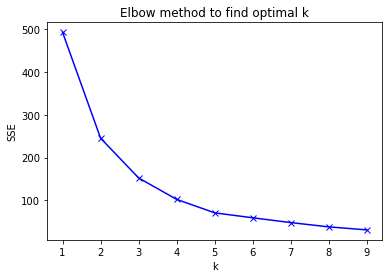

In [7]:
cluster_vars = ['bathroomcnt', 'bed_bath_ratio', 'calculatedfinishedsquarefeet']
explore.elbow_plot(X_train_scaled, cluster_vars)

#### Takeaway:

- Lets try 4 
***

### Step 2. Create Clusters

#### 2a. Train Cluster

In [8]:
train_clusters, kmeans = explore.run_kmeans(X_train, X_train_scaled, k=4, cluster_vars=cluster_vars, cluster_col_name = 'room_cluster')
train_clusters

,room_cluster
50028,3
16721,1
30822,1
4398,3
46912,3
...,...
39988,3
19901,3
51300,3
50259,2


In [9]:
# Create Clusters for Validate and Test
validate_clusters = explore.kmeans_transform(X_validate_scaled, kmeans, cluster_vars, cluster_col_name = 'room_cluster')
test_clusters = explore.kmeans_transform(X_test_scaled, kmeans, cluster_vars, cluster_col_name = 'room_cluster')

In [10]:
train_clusters.shape, validate_clusters.shape, test_clusters.shape

((18756, 1), (8039, 1), (6699, 1))

In [11]:
#Visualize distribution of clusters, they do not look even
train_clusters.room_cluster.value_counts()

3    10685
2     4561
1     1957
0     1553
Name: room_cluster, dtype: int64

#### 2b. Get Centroids

In [12]:
# Function that extracts centroids from k-means
centroids = explore.get_centroids(cluster_vars, cluster_col_name='room_cluster', kmeans= kmeans)
centroids

,room_cluster,centroid_bathroomcnt,centroid_bed_bath_ratio,centroid_calculatedfinishedsquarefeet
0,0,0.42,0.20,0.18
1,1,0.09,0.61,0.05
2,2,0.13,0.40,0.05
3,3,0.21,0.27,0.08


#### 2c. Append cluster id onto X_train & X_train_scaled, then join with the centroids dataframe.


In [13]:
X_train_scaled.shape, X_validate_scaled.shape, X_test_scaled.shape

((18756, 13), (8039, 13), (6699, 13))

In [14]:
# Function that appends Clusters and Centroids to train and validate df

X_train, X_train_scaled = explore.add_to_train(train_clusters, centroids, X_train, X_train_scaled, cluster_col_name = 'room_cluster')
X_train_explore, X_train_explore_scaled = explore.add_to_train(train_clusters, centroids, X_train_explore, X_train_explore_scaled, cluster_col_name = 'room_cluster')
X_validate, X_validate_scaled = explore.add_to_train(validate_clusters, centroids, X_validate, X_validate_scaled, cluster_col_name = 'room_cluster')
X_test, X_test_scaled = explore.add_to_train(test_clusters, centroids, X_test, X_test_scaled, cluster_col_name = 'room_cluster')

In [74]:
X_train_explore_scaled.shape, X_train_scaled.shape, X_validate_scaled.shape, X_test_scaled.shape

((18756, 18), (18756, 5), (8039, 5), (6699, 5))

#### 2d. Visualize room_clusters and centroids 

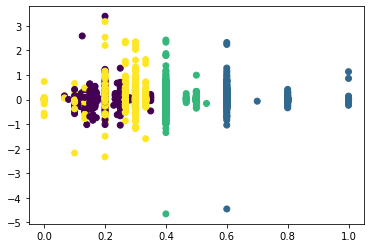

In [16]:
# Visualize 
plt.scatter(X_train_scaled.bed_bath_ratio, y_train.logerror, c=X_train_scaled.room_cluster)
plt.show()

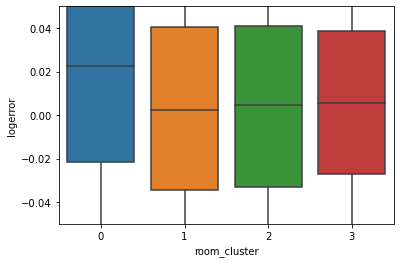

In [17]:
sns.boxplot(X_train_scaled.room_cluster, y_train.logerror)
plt.ylim(-.05,.05)
plt.show()

***

### Hypothesis Testing: (ANOVA)

Is there a staistically signfinicant difference between room_clusters and logerror?

***Null Hypothesis:*** Mean logerror is the same across all clusters

***Alternative Hypothesis:*** Mean logerror is different across clusters

**alpha=0.01**

#### Scale X_train_explore

In [75]:
#### ANOVA

cluster_0 = X_train_explore[X_train_explore.room_cluster == 0].logerror
cluster_1 = X_train_explore[X_train_explore.room_cluster == 1].logerror
cluster_2 = X_train_explore[X_train_explore.room_cluster == 2].logerror
cluster_3 = X_train_explore[X_train_explore.room_cluster == 3].logerror


from scipy.stats import f_oneway
f, p = f_oneway(cluster_0, cluster_1, cluster_2, cluster_3)
p

0.002257126133293565

***We fail to reject the null, indicating there is NO SIGNIFICANT DIFFERENCE in logerror between clusters***

***

In [20]:
cluster_0

10140                   0.04
2307                    0.09
7511                   -0.13
16411                  -0.03
40821                   0.10
                ...         
41799                   0.04
18987                  -0.01
14813                   0.08
26636                  -0.01
24027                  -0.09
Name: logerror, Length: 1553, dtype: float64

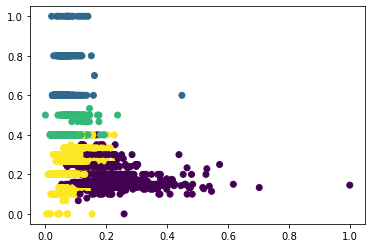

In [21]:
plt.scatter(X_train_scaled.calculatedfinishedsquarefeet, X_train_scaled.bed_bath_ratio, c=X_train_scaled.room_cluster)
plt.show()

<div class="alert alert-block alert-info"><b></b></div>

## Cluster Two: Size Clusters

- calculatedfinishedsquarefeet
- acres
- structure_dollar_per_sqft
- land_dollar_per_sqft

### Step 1. Elbow Plot

   k                  sse
0  1               108.02
1  2                76.69
2  3                62.47
3  4                53.76
4  5                47.29
5  6                41.53
6  7                36.89
7  8                32.90
8  9                29.97


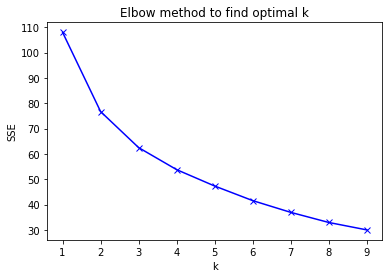

In [22]:
cluster_vars = ['calculatedfinishedsquarefeet', 'acres', 'structure_dollar_per_sqft', 'land_dollar_per_sqft']
explore.elbow_plot(X_train_scaled, cluster_vars)

**Takeaway:**

**K of 3 looks good here**

***

### Step 2. Create Clusters

#### 2a. Train Cluster

In [23]:
train_clusters, kmeans = explore.run_kmeans(X_train, X_train_scaled, k=3, cluster_vars=cluster_vars, cluster_col_name = 'size_cluster')

In [24]:
train_clusters

,size_cluster
50028,1
16721,0
30822,0
4398,0
46912,0
...,...
39988,1
19901,0
51300,0
50259,0


In [25]:
# Create Clusters for Validate and Test
validate_clusters = explore.kmeans_transform(X_validate_scaled, kmeans, cluster_vars, cluster_col_name = 'size_cluster')
test_clusters = explore.kmeans_transform(X_test_scaled, kmeans, cluster_vars, cluster_col_name = 'size_cluster')

In [26]:
#Visualize distribution of clusters, they do not look even
train_clusters.size_cluster.value_counts()

0    14640
1     3619
2      497
Name: size_cluster, dtype: int64

#### 2b. Get Centroids

In [27]:
# Function that extracts centroids from k-means
centroids = explore.get_centroids(cluster_vars, cluster_col_name='size_cluster', kmeans= kmeans)
centroids

,size_cluster,centroid_calculatedfinishedsquarefeet,centroid_acres,centroid_structure_dollar_per_sqft,centroid_land_dollar_per_sqft
0,0,0.06,0.00,0.05,0.02
1,1,0.14,0.00,0.08,0.03
2,2,0.14,0.00,0.22,0.16


#### 2c. Append cluster id onto X_train & X_train_scaled, then join with the centroids dataframe.

In [28]:
X_train_scaled.shape, X_validate_scaled.shape, X_test_scaled.shape

((18756, 17), (8039, 17), (6699, 17))

In [29]:
# Function that appends Clusters and Centroids to train and validate df
X_train, X_train_scaled = explore.add_to_train(train_clusters, centroids, X_train, X_train_scaled, cluster_col_name = 'size_cluster')
X_validate, X_validate_scaled = explore.add_to_train(validate_clusters, centroids, X_validate, X_validate_scaled, cluster_col_name = 'size_cluster')
X_test, X_test_scaled = explore.add_to_train(test_clusters, centroids, X_test, X_test_scaled, cluster_col_name = 'size_cluster')

In [30]:
X_train_scaled.shape, X_validate_scaled.shape, X_test_scaled.shape

((18756, 22), (8039, 22), (6699, 22))

### Step 3: Visualize room_clusters and centroids 

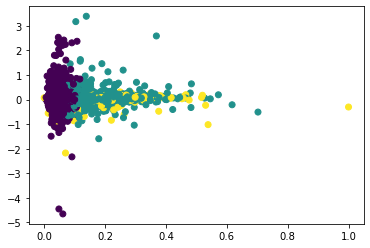

In [31]:
plt.scatter(X_train_scaled.calculatedfinishedsquarefeet, y_train.logerror, c=X_train_scaled.size_cluster)
plt.show()

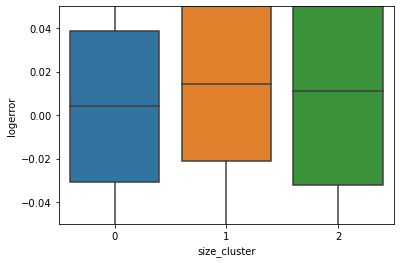

In [32]:
sns.boxplot(X_train_scaled.size_cluster, y_train.logerror)
plt.ylim(-.05,.05)
plt.show()

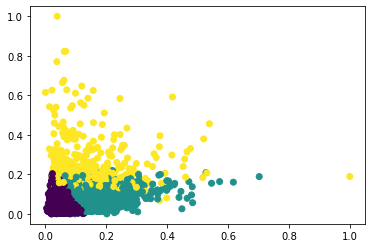

In [33]:
plt.scatter(X_train_scaled.calculatedfinishedsquarefeet, X_train_scaled.structure_dollar_per_sqft, c=X_train_scaled.size_cluster)
plt.show()

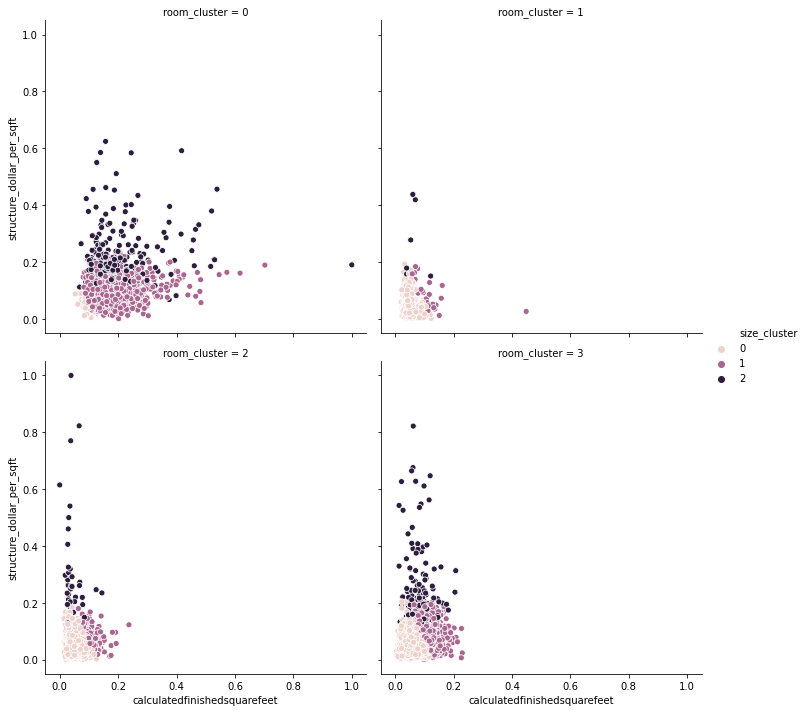

In [34]:
# visualize w/ hue="species" style="cluster"
sns.relplot(x="calculatedfinishedsquarefeet", y="structure_dollar_per_sqft", hue="size_cluster", col="room_cluster", col_wrap=2, data=X_train_scaled)
plt.show()

<div class="alert alert-block alert-info"><b></b></div>

## Cluster Three: Location Clusters (Location plus 2 created features)

- latitude
- longitude
- room_cluster
- size_cluster

### Step 1. Elbow Plot

   k                  sse
0  1            22,678.71
1  2             9,276.57
2  3             5,386.99
3  4             3,057.17
4  5             1,705.18
5  6             1,464.05
6  7             1,258.44
7  8             1,054.52
8  9               974.43


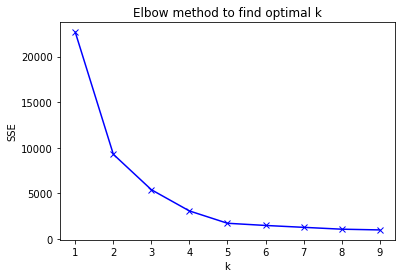

In [35]:
cluster_vars = ['latitude', 'longitude', 'room_cluster', 'size_cluster']
explore.elbow_plot(X_train_scaled, cluster_vars)

**Takeaway**

K = 3

### Step 2. Create Clusters

#### 2a. Train Cluster

In [36]:
train_clusters, kmeans = explore.run_kmeans(X_train, X_train_scaled, k=3, cluster_vars=cluster_vars, cluster_col_name = 'location_cluster')

In [37]:
# Create Clusters for Validate and Test
validate_clusters = explore.kmeans_transform(X_validate_scaled, kmeans, cluster_vars, cluster_col_name = 'location_cluster')
test_clusters = explore.kmeans_transform(X_test_scaled, kmeans, cluster_vars, cluster_col_name = 'location_cluster')

In [38]:
#Visualize distribution of clusters, they do not look even
train_clusters.location_cluster.value_counts()

0    10685
1     6481
2     1590
Name: location_cluster, dtype: int64

#### 2b. Get Centroids

In [39]:
# Function that extracts centroids from k-means
centroids = explore.get_centroids(cluster_vars, cluster_col_name='location_cluster', kmeans= kmeans)
centroids

,location_cluster,centroid_latitude,centroid_longitude,centroid_room_cluster,centroid_size_cluster
0,0,0.55,0.53,3.00,0.24
1,1,0.49,0.55,1.70,0.04
2,2,0.53,0.44,0.02,1.12


#### 2c. Append cluster id onto X_train & X_train_scaled, then join with the centroids dataframe.

In [40]:
X_train_scaled.shape, X_validate_scaled.shape, X_test_scaled.shape

((18756, 22), (8039, 22), (6699, 22))

In [41]:
X_train, X_train_scaled = explore.add_to_train(train_clusters, centroids, X_train, X_train_scaled, cluster_col_name = 'location_cluster')
X_validate, X_validate_scaled = explore.add_to_train(validate_clusters, centroids, X_validate, X_validate_scaled, cluster_col_name = 'location_cluster')
X_test, X_test_scaled = explore.add_to_train(test_clusters, centroids, X_test, X_test_scaled, cluster_col_name = 'location_cluster')

In [42]:
X_train_scaled.shape, X_validate_scaled.shape, X_test_scaled.shape

((18756, 27), (8039, 27), (6699, 27))

### Step 3: Visualize room_clusters and centroids 

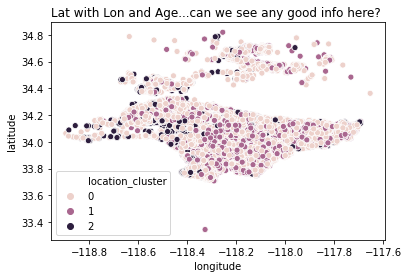

In [43]:
sns.scatterplot(x='longitude', y='latitude', hue='location_cluster', data=X_train)
plt.title("Lat with Lon and Age...can we see any good info here? ")
plt.show()

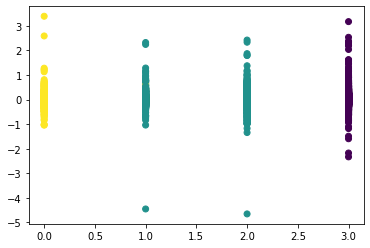

In [44]:
plt.scatter(X_train_scaled.room_cluster, y_train.logerror, c=X_train_scaled.location_cluster)
plt.show()

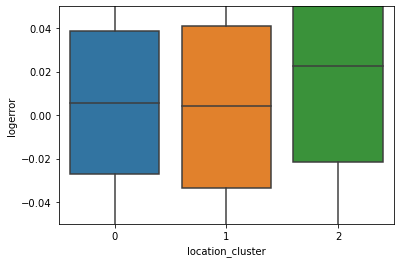

In [45]:
sns.boxplot(X_train_scaled.location_cluster, y_train.logerror)
plt.ylim(-.05,.05)
plt.show()

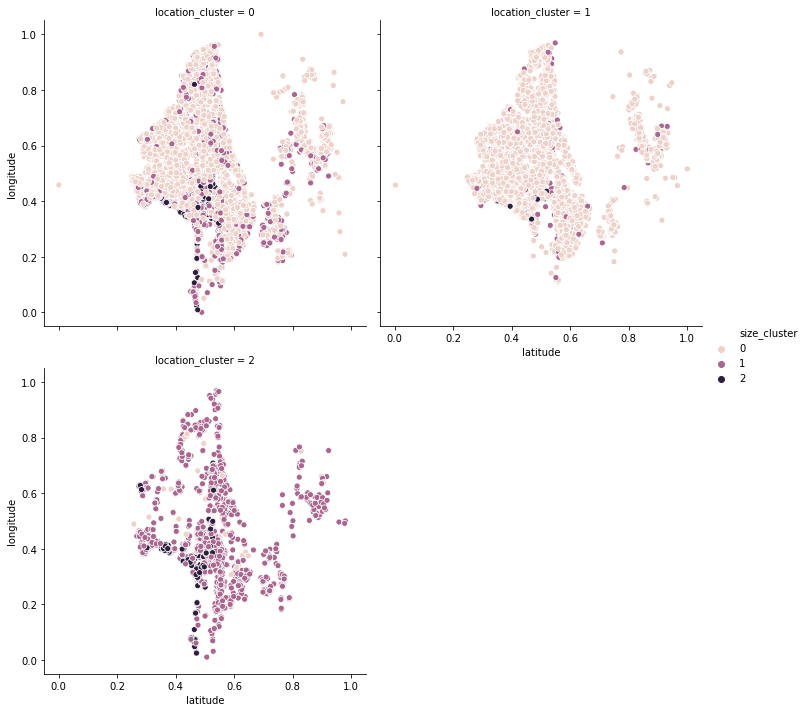

In [46]:
# visualize w/ hue="species" style="cluster"
sns.relplot(x="latitude", y="longitude", hue="size_cluster", col="location_cluster", col_wrap=2, data=X_train_scaled)
plt.show()

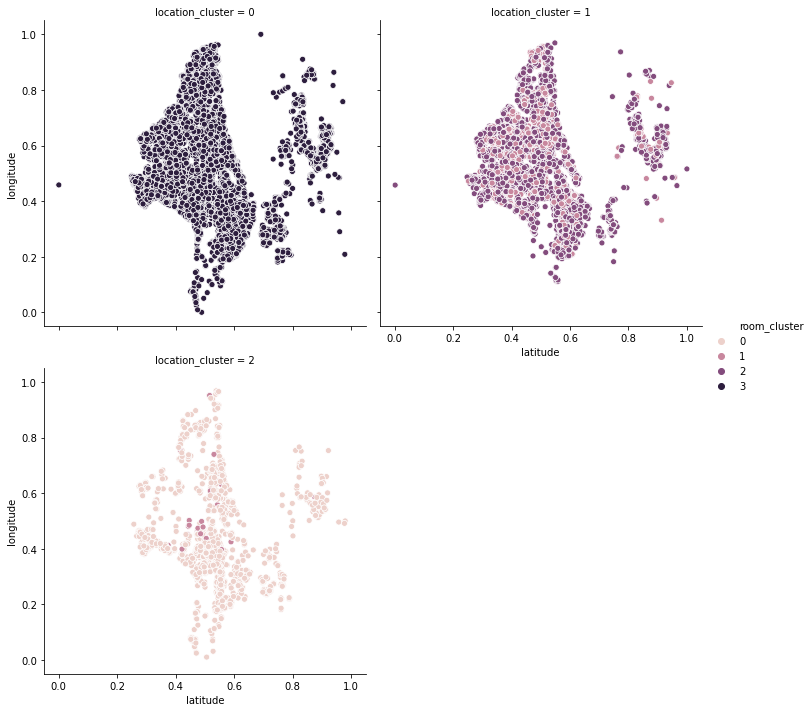

In [47]:
# visualize w/ hue="species" style="cluster"
sns.relplot(x="latitude", y="longitude", hue="room_cluster", col="location_cluster", col_wrap=2, data=X_train_scaled)
plt.show()

<div class="alert alert-block alert-info"><b></b></div>

# Characterizing Clusters 

### room_cluster

In [48]:
# Examining First Grouping (Room Cluster) Characteristics
X_train_scaled.groupby(['room_cluster'])['calculatedfinishedsquarefeet', 
                                 'bathroomcnt', 
                                  'bed_bath_ratio'].agg(['mean', 'median', 
                                               'std', 'min', 'max'])

calculatedfinishedsquarefeet                       \
                                     mean               median   
room_cluster                                                     
0                                    0.18                 0.16   
1                                    0.05                 0.04   
2                                    0.05                 0.05   
3                                    0.08                 0.07   

                                                                             \
                              std                  min                  max   
room_cluster                                                                  
0                            0.07                 0.05                 1.00   
1                            0.02                 0.02                 0.45   
2                            0.02                 0.00                 0.24   
3                            0.03                 0.00                 0.23   

                      bathroomcnt                                            \
                             mean               median                  std   
room_cluster                                                                  
0                            0.42                 0.36                 0.09   
1                            0.09                 0.09                 0.01   
2                            0.13                 0.09                 0.05   
3                            0.21                 0.18                 0.05   

                                                             bed_bath_ratio  \
                              min                  max                 mean   
room_cluster                                                                  
0                            0.27                 1.00                 0.20   
1                            0.00                 0.27                 0.61   
2                            0.09                 0.27                 0.40   
3                            0.09                 0.36                 0.27   

                                                                             \
                           median                  std                  min   
room_cluster                                                                  
0                            0.20                 0.04                 0.00   
1                            0.60                 0.06                 0.60   
2                            0.40                 0.02                 0.40   
3                            0.30                 0.05                 0.00   

                                   
                              max  
room_cluster                       
0                            0.40  
1                            1.00  
2                            0.53  
3                            0.40

**Takeaway:**   
Cluster 0 - low bed_bath_ratio (lots of bedrooms and lots of bathrooms)    
**1:1**   
Cluster 1 - large bed_bath_ratio (Many bedrooms, few to one bathroom)        
**3:1**   
Cluster 2 - med bed_bath_ratio (Many bedrooms, more than one bath)           
**2:1**   
Cluster 3 - low bed_bath_ratio (Many bedrooms, lots of bathrooms)            
**1.5:1**   

### size_cluster

In [49]:
# Examining Second Grouping (Room Cluster) Characteristics
X_train_scaled.groupby(['size_cluster'])['calculatedfinishedsquarefeet', 
                                 'acres','land_dollar_per_sqft', 
                                  'structure_dollar_per_sqft'].agg(['mean', 'median', 
                                               'std', 'min', 'max'])

calculatedfinishedsquarefeet                       \
                                     mean               median   
size_cluster                                                     
0                                    0.06                 0.06   
1                                    0.14                 0.12   
2                                    0.14                 0.11   

                                                                             \
                              std                  min                  max   
size_cluster                                                                  
0                            0.02                 0.00                 0.13   
1                            0.05                 0.04                 0.70   
2                            0.10                 0.00                 1.00   

                            acres                                            \
                             mean               median                  std   
size_cluster                                                                  
0                            0.00                 0.00                 0.02   
1                            0.00                 0.00                 0.01   
2                            0.00                 0.00                 0.00   

                                                       land_dollar_per_sqft  \
                              min                  max                 mean   
size_cluster                                                                  
0                            0.00                 1.00                 0.02   
1                            0.00                 0.41                 0.03   
2                            0.00                 0.02                 0.16   

                                                                             \
                           median                  std                  min   
size_cluster                                                                  
0                            0.01                 0.02                 0.00   
1                            0.02                 0.03                 0.00   
2                            0.14                 0.13                 0.01   

                                  structure_dollar_per_sqft  \
                              max                      mean   
size_cluster                                                  
0                            0.22                      0.05   
1                            0.23                      0.08   
2                            1.00                      0.22   

                                                                             \
                           median                  std                  min   
size_cluster                                                                  
0                            0.05                 0.03                 0.00   
1                            0.08                 0.03                 0.00   
2                            0.19                 0.12                 0.04   

                                   
                              max  
size_cluster                       
0                            0.20  
1                            0.23  
2                            1.00

**Takeaway**

Cluster 0 - Low Cost Per square foot   
**low_cost**   
Cluster 1 - Medium Cost Per Squre Foot   
**medium_cost**   
Cluster 2 - High Cost per squre foot   
**high_cost**   

### location_cluster

In [50]:
# Examining Third Grouping (loation Cluster) Characteristics
X_train_scaled.groupby(['location_cluster'])['latitude', 
                                 'longitude','room_cluster', 
                                  'size_cluster'].agg(['mean', 'median', 
                                               'std', 'min', 'max'])

latitude                       \
                                 mean               median   
location_cluster                                             
0                                0.55                 0.53   
1                                0.49                 0.47   
2                                0.53                 0.53   

                                                            \
                                  std                  min   
location_cluster                                             
0                                0.17                 0.00   
1                                0.14                 0.00   
2                                0.13                 0.26   

                                                 longitude  \
                                  max                 mean   
location_cluster                                             
0                                0.98                 0.53   
1                                1.00                 0.55   
2                                0.98                 0.44   

                                                            \
                               median                  std   
location_cluster                                             
0                                0.53                 0.18   
1                                0.55                 0.16   
2                                0.40                 0.17   

                                                            \
                                  min                  max   
location_cluster                                             
0                                0.00                 1.00   
1                                0.11                 0.97   
2                                0.01                 0.97   

                         room_cluster                                      \
                                 mean median                  std min max   
location_cluster                                                            
0                                3.00      3                 0.00   3   3   
1                                1.70      2                 0.46   1   2   
2                                0.02      0                 0.15   0   1   

                         size_cluster                                      
                                 mean median                  std min max  
location_cluster                                                           
0                                0.24      0                 0.47   0   2  
1                                0.04      0                 0.23   0   2  
2                                1.12      1                 0.41   0   2

**Takeaway:**

Cluster 0 - Large # of Rooms, Medium
Cluster 1 - Medium # of Rooms, Small
Cluster 2 - Small # of Rooms, High


<div class="alert alert-block alert-info"><b></b></div>

# Modeling

### Feature Selection:

In [51]:
X_train_scaled.shape, X_validate_scaled.shape, X_test_scaled.shape

((18756, 27), (8039, 27), (6699, 27))

In [52]:
# Split clusters in to dummy varaibles for modeling

X_train_scaled = pd.get_dummies(X_train_scaled,
                           columns=['room_cluster','size_cluster','location_cluster'])
X_validate_scaled = pd.get_dummies(X_validate_scaled,
                           columns=['room_cluster','size_cluster','location_cluster'])
X_test_scaled = pd.get_dummies(X_test_scaled,
                           columns=['room_cluster','size_cluster','location_cluster'])


X_train_scaled.shape, X_validate_scaled.shape, X_test_scaled.shape

((18756, 34), (8039, 34), (6699, 34))

In [53]:
# Which Features KBest?

top_3 = SelectKBest(f_regression, k=3).fit(X_train_scaled, y_train)
top_3_support = top_3.get_support()
X_train_scaled.loc[:,top_3_support].columns.tolist()

['structure_dollar_per_sqft', 'land_dollar_per_sqft', 'location_cluster_2']

In [54]:
# Which Features RFE?

lm = LinearRegression()
rfe = RFE(lm, n_features_to_select = 5)
rfe.fit(X_train_scaled, y_train)
ranks = rfe.ranking_
names = X_train_scaled.columns.tolist()
pd.DataFrame({'features': names, 'rank': ranks}).set_index('rank')

,features
rank,
25,bathroomcnt
30,calculatedfinishedsquarefeet
27,latitude
29,longitude
21,LA
20,Orange
19,Ventura
28,age
23,taxrate


**Takeaway**

***Going to model on top features (Ranked #1) Five Total***
1. size_cluster_0
2. size_cluster_1
3. size_cluster_2
4. centroid_structure_dollar_per_sqft
5. centroid_bathroomcnt

***

### Building the Model 

MVP - 3 Features

1. size_cluster_0
2. size_cluster_1
3. size_cluster_2
4. centroid_structure_dollar_per_sqft
5. centroid_bathroomcnt

***Target = logerror***

*Use all four common regression model types: Linear Regression, LassoLars, Polynomial Features, TweedieRegressor*

Establish Baseline based on target mean, if model Root Mean Squared Error (RMSE) is lower than the baseline the model performs better


#### Create a Baseline:

In [55]:
#Visualize Target
mean = np.mean(y_train)
median = np.median(y_train)

In [56]:
print("The mean value of y_train is")
mean

The mean value of y_train is


logerror                   0.01
dtype: float64

In [57]:
print("The median value of y_train is")
median

The median value of y_train is


0.006145192801565

In [58]:
y_train.describe()

,logerror
count,"18,756.00"
mean,0.01
std,0.16
min,-4.66
25%,-0.03
50%,0.01
75%,0.04
max,3.39


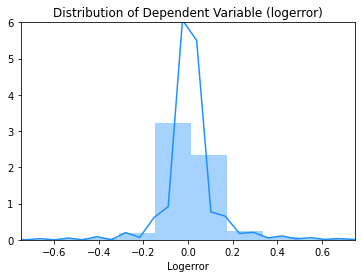

In [59]:
sns.distplot(y_train, color="dodgerblue", label="Compact", rug = False, axlabel = 'Logerror')
plt.xlim(-.75,.75)
plt.ylim(0, 6)
plt.title("Distribution of Dependent Variable (logerror)")
plt.show()

**Takeaway**

***Normal Distribution, will use Mean Value for Baseline***

#### Calcuate Baseline RMSE

In [60]:
# Mean Value
np.mean(y_train)
y_train.shape

(18756, 1)

In [61]:
# encode as variable
# np.full modiefies shape turns value in to a full series object
baseline_rmse = mean_squared_error(y_train, np.full(18756, np.mean(y_train)))**(1/2)
print (f'The baseline_rmse is {baseline_rmse}')  # Model Error To Beat 0.16287423418470207

The baseline_rmse is 0.16287423418470207


#### Specifiy Variables for Modeling

In [62]:
# Only Use centroid_calculatedfinishedsquarefeet_x, structure_dollar_per_sqft, centroid_land_dollar_per_sqft

X_train_scaled = X_train_scaled[['size_cluster_0', 'size_cluster_1', 'size_cluster_2', 'centroid_structure_dollar_per_sqft', 'centroid_bathroomcnt']]
X_validate_scaled = X_validate_scaled[['size_cluster_0', 'size_cluster_1', 'size_cluster_2', 'centroid_structure_dollar_per_sqft', 'centroid_bathroomcnt']]
X_test_scaled = X_test_scaled[['size_cluster_0', 'size_cluster_1', 'size_cluster_2', 'centroid_structure_dollar_per_sqft', 'centroid_bathroomcnt']]

In [63]:
X_train_scaled.shape, X_validate_scaled.shape, X_test_scaled.shape

((18756, 5), (8039, 5), (6699, 5))

### Train

#### Linear Regression

In [64]:
# Make Model
lm = LinearRegression(normalize=True)
# Fit Model
lm.fit(X_train_scaled, y_train)
# Make Predictions
lm_pred = lm.predict(X_train_scaled)
# Compute root mean squared error
lm_rmse = mean_squared_error(y_train, lm_pred)**(1/2)
lm_rmse

0.16277265035761898

#### Lassolars

In [65]:
# Make a model
lars = LassoLars(alpha=1)
# Fit a model
lars.fit(X_train_scaled, y_train)
# Make Predictions
lars_pred = lars.predict(X_train_scaled)
# Computer root mean squared error
lars_rmse = mean_squared_error(y_train, lars_pred)**(1/2)
lars_rmse

0.16287423418470207

#### Polynomial Featues

In [66]:
# Make a model
pf = PolynomialFeatures(degree=2)

# Fit and Transform model
# to get a new set of features..which are the original features sqauared
X_train_squared = pf.fit_transform(X_train_scaled)
X_validate_squared = pf.transform(X_validate_scaled)  
X_test_squared = pf.transform(X_test_scaled)          

# Feed new features in to linear model. 
lm_squared = LinearRegression(normalize=True)
lm_squared.fit(X_train_squared, y_train)
# Make predictions
lm_squared_pred = lm_squared.predict(X_train_squared)
# Compute root mean squared error
lm_squared_rmse = mean_squared_error(y_train, lm_squared_pred)**(1/2)
lm_squared_rmse

0.16273565694257736

#### Tweedie Regressor

In [67]:
# Make Model
tw = TweedieRegressor(power=0, alpha=0.1) # 0 = normal distribution
# Fit Model
tw.fit(X_train_scaled, y_train)
# Make Predictions
tw_pred = tw.predict(X_train_scaled)
# Compute root mean squared error
tw_rmse = mean_squared_error(y_train, tw_pred)**(1/2)
tw_rmse

0.16282494737498318

**Takeaway:**

- Top 3 preforming models are Linear, Polynomial, Tweedie
- These models will move on to Validate

### Validate:

#### Linear Regression

In [68]:
# Make Predictions
lm_pred_v = lm.predict(X_validate_scaled)
# Compute root mean squared error
lm_rmse_v = mean_squared_error(y_validate, lm_pred_v)**(1/2)
lm_rmse_v

0.1750284961482565

#### Ploynomial Features

In [69]:
# Feed new features in to linear model. 
lm_squared = LinearRegression(normalize=True)
lm_squared.fit(X_validate_squared, y_validate)
# Make predictions
lm_squared_pred_v = lm_squared.predict(X_validate_squared)
# Compute root mean squared error
lm_squared_rmse_v = mean_squared_error(y_validate, lm_squared_pred_v)**(1/2)
lm_squared_rmse_v

0.1749872815641925

#### Tweedie Regressor

In [70]:
# Make predictions
tw_pred_v = tw.predict(X_validate_scaled)
# Compute root mean squared error
tw_rmse_v = mean_squared_error(y_validate, tw_pred_v)**(1/2)
tw_rmse_v

0.17506029712614762

***

**Takeaway:**

On unseen data the Polynomial Model performs the best and will move on to the test data



***

### Test:

#### Polynomial Featues

In [71]:
# Feed new features in to linear model. 
lm_squared = LinearRegression(normalize=True)
lm_squared.fit(X_test_squared, y_test)
# Make predictions
lm_squared_pred_t1 = lm_squared.predict(X_test_squared)
# Compute root mean squared error
lm_squared_rmse_t1 = round(mean_squared_error(y_test, lm_squared_pred_t1)**(1/2),2)
lm_squared_rmse_t1

0.17

#### Average Model Error (Validate + Test) / 2

In [72]:
# Avg. Error = (Validate Error + Test Error) /2 - Average preformance of model works on unseen data
model_error = round((lm_squared_rmse_v + lm_squared_rmse_t1) / 2 , 2)
print(f'The average error for our model is {model_error}%')

The average error for our model is 0.17%


#### Percentage Improvement over Baseline

In [73]:
# Calcuating % improvement
# First: work out the difference (increase) between the two numbers you are comparing
difference = (baseline_rmse - lm_squared_rmse_t1)
# Then: divide the increase by the original number and multiply the answer by 100
percent_improve = round((difference / baseline_rmse) * 100, 2)
print(f'The % improvement for our model is {percent_improve}%')

The % improvement for our model is -4.38%


**Takeaway:**

- Polynomial Features is the model that best predicts logerror
- This model produces an average error of 0.17%
- This represents a **-4.38%** improvement over baseline


<div class="alert alert-block alert-info"><b></b></div>

# Conclusions


**Summary:**

*Exploration:*

1. Filtered data down to 13 variables:
       - wrangle module
       
2. Developed Clusters:
       A. room_cluster (information that reflects the number and size of rooms per unit)
       B. size_cluster (information that reflects the size of the home and property in squarefeet)
       C. location_clusters (informaiton that reflects the location of proerties along with previous clusters)
       
3. Hypothesis Testing:


Top 5 variables for modeling (bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet, garage, zip_cc)
    Validated using SlectKBest and RFE
    Variables passed F-Test with p-value < 0.05, indicating 95% certainty the indipendent variables explains the relationship (r-value)

*Statistical Testing:*

    Chi Squared Test for Independence: bedroomcnt and bathroomcnt
        Rejected Null: 95% Confidence Variabes show dependence
    Independent T-Test: Preformed on fireplace and total square feet
        Rejected Null: 95% Confidence that there is a difference (in terms of square footage) between houses with or without a fireplace

*Modeling: (3 Iterations)*

    4 model: Linear Regression, LassoLars, Polynomial Features, TweedieRegressor
        Target = taxvaluedollarcnt

    First Iteration (3 Features, degree = 2)
    Features = bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet
    Best Model = Polynomial Feature Model
    Avg. RMSE of $464997.75
    28% Improvement over baseline

    Second Iteration (5 Features, degree = 2)
    Features = bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet, garage, zip_cc
    Model = Polynomial Feature Model
    Avg. RMSE of $447039.41
    31% Improvement over baseline
    Effect On Model - RFE Features Improve Preformance

    Third Iteration (5 Features, degree = 5) Features = bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet, garage, zip_cc Model = Polynomial Features Model
    Avg. RMSE of $442704.79
    31% Improvement over baseline
    Effect On Model - Overfit, loss of predictive power on unseen data

